In [289]:
import pandas as pd
import numpy as np
import investpy
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [17, 5]

In [299]:
def getExponentialMovingAverage(close, days):
    ema = []
    ema.append(close[0])
    smooth = 2/(days+1) 
    for i in range(1,len(close)):
        ema.append(close[i] * smooth + ema[i-1] * (1-smooth))
    return ema

##missing 3 rows
def expandMovingAverage(movingAverage, interval):
    index = 0
    ma_stock = pd.DataFrame(columns = ["MA" + str(interval)])
    for i in range(0,len(movingAverage)-1):
        ma_stock.loc[index] = movingAverage.iloc[i] ##adds the n element to the series
        diff = ((movingAverage.iloc[i+1] - movingAverage.iloc[i])/interval)
        mult = 1
        index += 1
        for a in range(index, index + interval - 1):
            ma_stock.loc[index] = (diff * mult) + movingAverage.iloc[i] #adds the difference between the n and n+1 to the series
            mult += 1
            index += 1
    return ma_stock

In [300]:
stocks = investpy.get_stocks_list()
def getInfo(stock, country, from_date, to_date, interval):
    stock = investpy.get_stock_historical_data(stock=stock, country=country, from_date=from_date, to_date=to_date)

    fig, chart = plt.subplots()
    getSMA = stock['Close'].groupby(np.arange(len(stock['Close']))//interval).mean()
    ema_stock = getExponentialMovingAverage(getSMA, interval)
    ema_stock = pd.Series(ema_stock)
    ema_stock = expandMovingAverage(ema_stock, interval)
    sma_stock = expandMovingAverage(getSMA, interval)
    
    stock['High'].reset_index(drop = True, inplace = True)
    stock['Open'].reset_index(drop = True, inplace = True)
    stock['Low'].reset_index(drop = True, inplace = True)
    stock['Close'].reset_index(drop = True, inplace = True)

    chart.plot(stock['Close'], label="close", linewidth = 1, linestyle=':')
    chart.plot(stock['High'], label="high", linewidth = 1, linestyle=':')
    chart.plot(stock['Low'], label="low", linewidth = 1, linestyle=':')
    chart.plot(stock['Open'], label="open", linewidth = 1, linestyle=':')
    chart.plot(sma_stock, label="SMA" + str(interval))
    chart.plot(ema_stock, label="EMA" + str(interval))
    chart.legend(loc="lower right")
    plt.show()

##if stock info is not indexed
def searchAndGetInfo(stock, country, from_date, to_date, interval):
    search_results = investpy.search_quotes(text = stock, countries=[country], n_results=1)
    stock = search_results[0].retrieve_historical_data(from_date=from_date, to_date=to_date)

    fig, chart = plt.subplots()
    getSMA = stock['Close'].groupby(np.arange(len(stock['Close']))//interval).mean()
    ema_stock = getExponentialMovingAverage(getSMA, interval)
    ema_stock = pd.Series(ema_stock)
    ema_stock = expandMovingAverage(ema_stock, interval)
    sma_stock = expandMovingAverage(getSMA, interval)
    
    stock['High'].reset_index(drop = True, inplace = True)
    stock['Open'].reset_index(drop = True, inplace = True)
    stock['Low'].reset_index(drop = True, inplace = True)
    stock['Close'].reset_index(drop = True, inplace = True)

    chart.plot(stock['Close'], label="close", linewidth = 1, linestyle=':')
    chart.plot(stock['High'], label="high", linewidth = 1, linestyle=':')
    chart.plot(stock['Low'], label="low", linewidth = 1, linestyle=':')
    chart.plot(stock['Open'], label="open", linewidth = 1, linestyle=':')
    chart.plot(sma_stock, label="SMA" + str(interval))
    chart.plot(ema_stock, label="EMA" + str(interval))
    chart.legend(loc="lower right")
    plt.show()

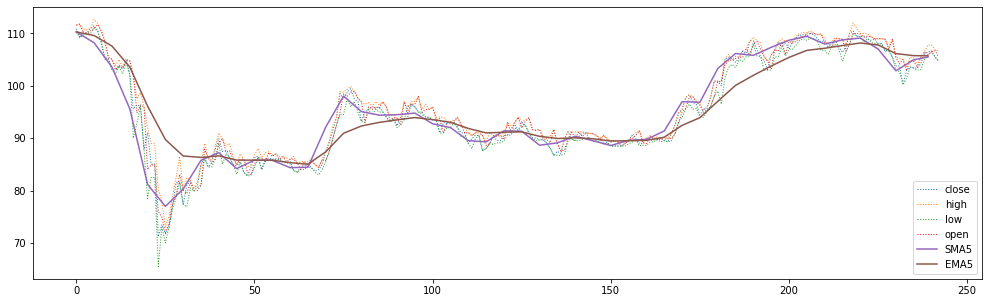

In [301]:
getInfo('FMETF','philippines', '13/2/2020', '17/2/2021', 5)

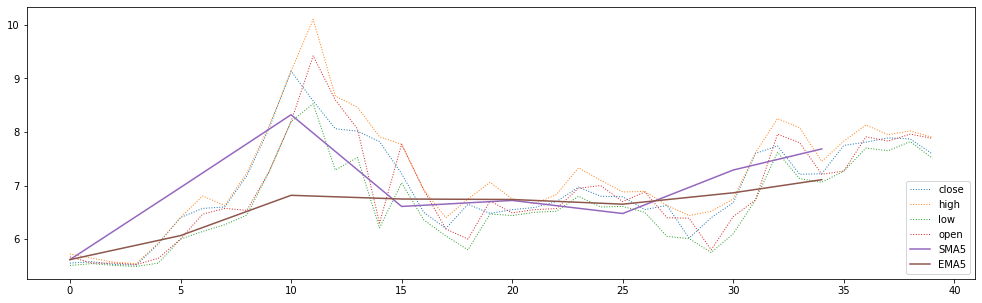

In [302]:
searchAndGetInfo('ACEN', 'Philippines', '13/12/2020', '17/2/2021', 5)

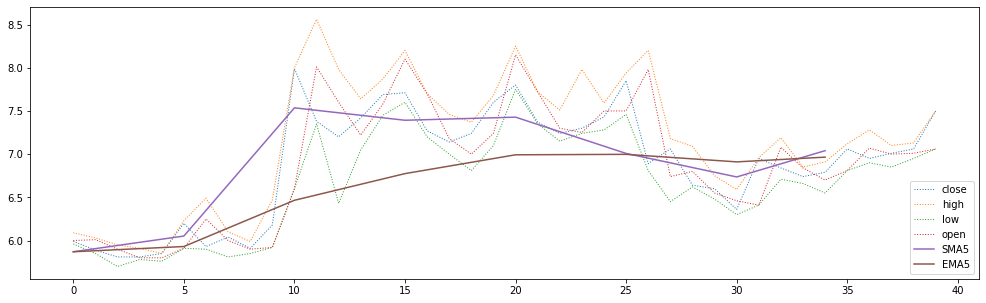

In [303]:
searchAndGetInfo('MM', 'Philippines', '13/12/2020', '17/2/2021', 5)

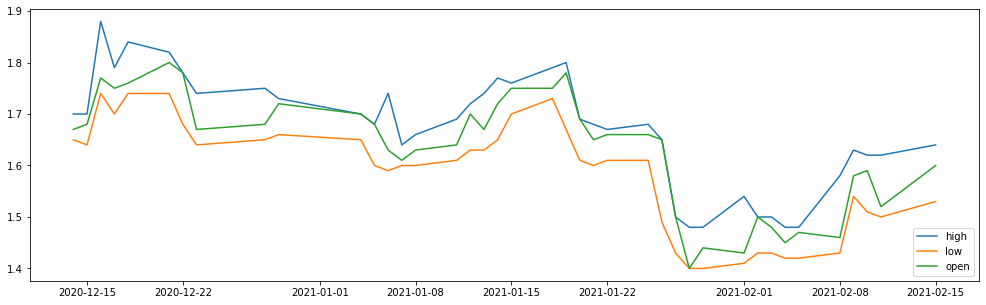

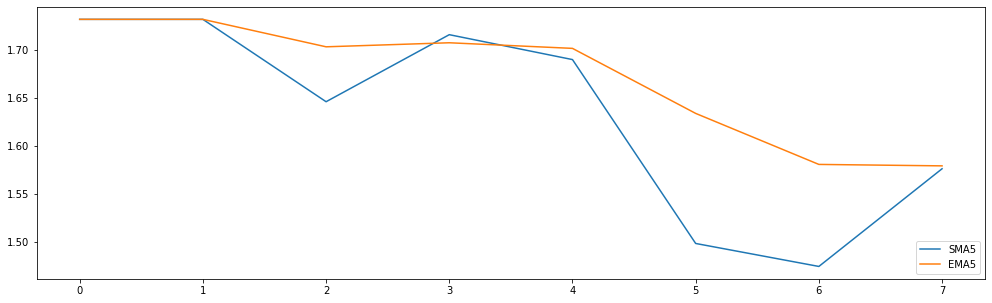

In [9]:
searchAndGetInfo('FRUIT', 'Philippines', '13/12/2020', '15/2/2021', 5)

In [10]:
##find support and resistance
##try to find a trend
####find when a trend has started and is about to change